All needed libraries and steps

In [72]:
#!pip3 install plotly==4.14.3
#!pip3 install -U datapane
#!sudo pip3 install matplotlib
#!pip3 install -U scikit-learn scipy matplotlib
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 --allow-root

import plotly.express as px
from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots
from pandas import DataFrame
from datetime import datetime, date, time, timedelta
import pandas as pd
import numpy as np
import datapane as dp
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import islice
import plotly.graph_objects as go
import json

Data Import

In [47]:
#Import LTE network data from JSON file
data = []
with open('LTE.json') as f:
    for line in f:
        data.append(json.loads(line))

        #Convert JSON data from Python dict to DF
LTE_DATA = pd.json_normalize(data)
LTE_DATA.head()

#Import LTE network Ping data from JSON file
data = []
with open('Ping.json') as f:
    for line in f:
        data.append(json.loads(line))

        #Convert JSON data from Python dict to DF
LTE_PING = pd.json_normalize(data)
LTE_PING.head()

interface                   timestamp  net_param.avg_latency  \
0      eth1  2021-05-22 13:50:22.168969                 47.028   
1      eth1  2021-05-22 13:50:22.168969                 47.028   
2      eth1  2021-05-22 13:50:37.145031                 38.270   
3      eth1  2021-05-22 13:50:37.145031                 38.270   
4      eth1  2021-05-22 13:50:52.237218                 43.785   

   net_param.max_latency  net_param.packet_loss_rate uav_param.mode  \
0                 68.930                         0.0        POSHOLD   
1                 68.930                         0.0        POSHOLD   
2                 46.956                         0.0        POSHOLD   
3                 46.956                         0.0        POSHOLD   
4                 68.989                         0.0        POSHOLD   

  uav_param.status uav_param.battery uav_param.attitude.pitch  \
0          STANDBY             24.48     -0.03359268605709076   
1          STANDBY             24.48     -0.03359268605709076   
2          STANDBY            24.478    -0.033754583448171616   
3          STANDBY            24.478    -0.033754583448171616   
4          STANDBY            24.474    -0.033050715923309326   

  uav_param.attitude.yaw  ... gps_param.altitude gps_param.groundspeed  \
0    -3.1376469135284424  ...              16.52   0.11406989395618439   
1    -3.1376469135284424  ...              16.52   0.11406989395618439   
2    -3.1396305561065674  ...              16.61   0.11199898272752762   
3    -3.1396305561065674  ...              16.61   0.11199898272752762   
4     3.1409029960632324  ...              16.65    0.1331551969051361   

  gps_param.velocity.vx gps_param.velocity.vy gps_param.velocity.vz  \
0                 -0.08                  0.07                  0.09   
1                 -0.08                  0.07                  0.09   
2                 -0.06                  0.09                  0.08   
3                 -0.06                  0.09                  0.08   
4                 -0.08                   0.1                  0.08   

  gps_param.head gps_param.hdop gps_param.vdop gps_param.satellites  \
0            180             71            105                   15   
1            180             71            105                   15   
2            180             71            105                   15   
3            180             71            105                   15   
4            179             71            106                   15   

  gps_param.fix_type  
0                  4  
1                  4  
2                  4  
3                  4  
4                  4  

[5 rows x 23 columns]

Preliminary Data Clean

In [48]:
#Drop duplicate data where rows have same timestamp
LTE_DATA = LTE_DATA.drop_duplicates(subset=['timestamp'])
LTE_PING = LTE_PING.drop_duplicates(subset=['timestamp'])

#Set LTE condition
LTE_net = LTE_DATA['net_param.net_type']=='LTE'
LTE_DATA = LTE_DATA[LTE_net]

#Replace all that values at the boudaries with integer values, so that they can be converted into float
LTE_DATA = LTE_DATA.replace(['>=-51','<=-113','<-20','<-19.5','<-140'],['-50','-120','-21','-20','-144'])

#Converto DF into float (only numbers)
LTE_DATA = LTE_DATA.apply(pd.to_numeric, errors='ignore')
LTE_PING = LTE_PING.apply(pd.to_numeric, errors='ignore')

#Set GPS_Fix condition
LTE_Null = LTE_DATA['gps_param.satellites']>=6
LTE_DATA = LTE_DATA[LTE_Null]
PING_Null = LTE_PING['gps_param.satellites']>=6
LTE_PING = LTE_PING[PING_Null]

#Convert timestamp into datetime
LTE_DATA["timestamp"] = pd.to_datetime(LTE_DATA["timestamp"])
LTE_PING["timestamp"] = pd.to_datetime(LTE_PING["timestamp"])

#Sort by time (needed for time clustering)
LTE_DATA = LTE_DATA.sort_values(by="timestamp")
LTE_PING = LTE_PING.sort_values(by="timestamp")

#Print Dtypes for debug
print(LTE_DATA.dtypes)
print(LTE_PING.dtypes)

interface                           object
timestamp                   datetime64[ns]
net_param.net_type                  object
net_param.rsrq                     float64
net_param.rsrp                       int64
net_param.rssi                       int64
net_param.sinr                       int64
net_param.band                       int64
net_param.pci                        int64
uav_param.mode                      object
uav_param.status                    object
uav_param.battery                  float64
uav_param.attitude.pitch           float64
uav_param.attitude.yaw             float64
uav_param.attitude.roll            float64
gps_param.latitude                 float64
gps_param.longitude                float64
gps_param.altitude                 float64
gps_param.groundspeed              float64
gps_param.velocity.vx              float64
gps_param.velocity.vy              float64
gps_param.velocity.vz              float64
gps_param.head                       int64
gps_param.h

Time clustering to separate different flight mission

In [52]:
#Convert timestamp of dataframe to python datetime
LTE_DATA.timestamp = LTE_DATA.timestamp.dt.to_pydatetime()
LTE_PING.timestamp = LTE_PING.timestamp.dt.to_pydatetime()
#LTE_DATA['timestamp'][100:450]

#CLUSTER LTE DF
#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=2)
final = list()
tmp = list()

#First row
tmp.append(LTE_DATA.iloc[0,:])

#First datetime
previous = LTE_DATA.iloc[0,1]

#Scan LTE dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LTE_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 100 rows
lte_flights = []
for i in range(len(final)):
    if len(final[i])>100:
        lte_flights.append(final[i])

#Print N° of flights
print("Found ", len(lte_flights), " flights with LTE network data")

#Print flight lenght
for i in range(len(lte_flights)):
    print("Flight N°", i+1, "has ", len(lte_flights[i]), " rows of data")


#CLUSTER LTE_PING DF
#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=3)
final = []
tmp = []

#First row
tmp.append(LTE_PING.iloc[0,:])

#First datetime
previous = LTE_PING.iloc[0,1]

#Scan LTE dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LTE_PING.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 100 rows
lte_ping_flights = []
for i in range(len(final)):
    if len(final[i])>10:
        lte_ping_flights.append(final[i])

#Print N° of flights
print("Found ", len(lte_ping_flights), " flights with LTE Ping network data")

#Print flight lenght
for i in range(len(lte_ping_flights)):
    print("Flight N°", i+1, "has ", len(lte_ping_flights[i]), " rows of data")


Found  10  flights with LTE network data
Flight N° 1 has  517  rows of data
Flight N° 2 has  867  rows of data
Flight N° 3 has  920  rows of data
Flight N° 4 has  669  rows of data
Flight N° 5 has  635  rows of data
Flight N° 6 has  680  rows of data
Flight N° 7 has  489  rows of data
Flight N° 8 has  392  rows of data
Flight N° 9 has  376  rows of data
Flight N° 10 has  612  rows of data
Found  10  flights with LTE Ping network data
Flight N° 1 has  35  rows of data
Flight N° 2 has  61  rows of data
Flight N° 3 has  93  rows of data
Flight N° 4 has  68  rows of data
Flight N° 5 has  64  rows of data
Flight N° 6 has  72  rows of data
Flight N° 7 has  48  rows of data
Flight N° 8 has  61  rows of data
Flight N° 9 has  63  rows of data
Flight N° 10 has  63  rows of data


In [112]:
#All the plot function
def Scatter_plot_speed(DF):
    #Define figure
    fig_speed_scat = go.Figure()
 
    #Clean DF in order to keep only measurment at the "same" altitude, thus removing dependency on altitude
    MAX_Alt = DF['gps_param.altitude'].max()
    CUT_Alt = MAX_Alt*0.85 #Keep only the real flight data
    DF_Pos = DF['gps_param.altitude']>CUT_Alt
    DF = DF[DF_Pos]
    fig_speed_scat.add_trace(go.Scatter(x=DF['gps_param.groundspeed'], y=DF['net_param.sinr'], mode='markers', name='SNR'))
    fig_speed_scat.add_trace(go.Scatter(x=DF['gps_param.groundspeed'], y=DF['net_param.rsrq'], mode='markers', name='RSRQ'))
    
    #Linear Reg for SNR
    model = LinearRegression()
    X = DF['gps_param.groundspeed'].values.reshape(-1,1)
    model.fit(X, DF['net_param.sinr'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression to plot 
    fig_speed_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='SNR Lin Reg'))
   
    #Linear Reg for RSRQ
    model = LinearRegression()
    model.fit(X, DF['net_param.rsrq'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression
    fig_speed_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='RSRQ Lin Reg'))
    
    #Set plots names
    fig_speed_scat.update_layout(title_text="SNR & RSRQ vs UAV Speed")
    
    #Set Axis name
    fig_speed_scat.update_xaxes(title_text="UAV Speed (m/s)")
    fig_speed_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_speed_scat.show()
        
def Scatter_plot_alt(DF):
    #Define figure
    fig_scat = go.Figure()

    #Plot signal quality index by altitude       
    fig_scat.add_trace(go.Scatter(x=DF['gps_param.altitude'], y=DF['net_param.sinr'], mode='markers', name='SNR'))
    fig_scat.add_trace(go.Scatter(x=DF['gps_param.altitude'], y=DF['net_param.rsrq'], mode='markers', name='RSRQ'))

    #Linear Reg for SNR
    model = LinearRegression()
    X = DF['gps_param.altitude'].values.reshape(-1,1)
    model.fit(X, DF['net_param.sinr'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression to plot 
    fig_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='SNR Lin Reg'))
    
    #Linear Reg for RSRQ
    model = LinearRegression()
    model.fit(X, DF['net_param.rsrq'])
    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))
    
    #Add Linear Regression
    fig_scat.add_trace(go.Scatter(x=x_range, y=y_range, name='RSRQ Lin Reg'))

    #Set plots names
    fig_scat.update_layout(title_text="SNR & RSRQ vs UAV Altitude")

    #Set Axis name
    fig_scat.update_xaxes(title_text="UAV Altitude (m)")
    fig_scat.update_yaxes(title_text="dBm")
    
    #Show plots
    fig_scat.show()
    

def Scatter_map(DF):
    #Create scatter maps
    scat_map = px.scatter_mapbox(DF, lat='gps_param.latitude', lon='gps_param.longitude', color='net_param.sinr', size='gps_param.longitude', zoom=16,
                        mapbox_style="open-street-map")
    
    # Set plot name
    scat_map.update_layout(title_text="LTE Coverage Map")
    
    # Show
    scat_map.show()
    
def Flight_plot(DF):   
    #Flight match between the two DF
    first_LTE_time = lte_complete_flights[f].iloc[0,1]
    delta = timedelta(minutes=1)
    for i in range(len(lte_ping_complete_flights)):
        first_LTE_ping_time = lte_ping_complete_flights[i].iloc[0,1]    
        if abs(first_LTE_ping_time - first_LTE_time) < delta:
            print("Matched LTE Flight N°", f+1,"with LTE Ping Flight N°",i+1)
            DF_ping = DataFrame (lte_ping_complete_flights[i])
            
    # Create figure with secondary y-axis
    fig_lines = make_subplots(specs=[[{"secondary_y": True}]])

    #Set first axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.sinr'], name="SINR (dBm)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['gps_param.altitude'], name="Altitude (m)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['gps_param.groundspeed'], name="Groundspeed (m/s)"), secondary_y=False)
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.rsrq'], name="RSRQ (dBm)"), secondary_y=False)
    try:
        #Cutoff big ping value to 100, which is already an ugly value
        DF_ping['net_param.avg_latency'][DF_ping['net_param.avg_latency']>100] = 100
        fig_lines.add_trace(go.Scatter(x=DF_ping['timestamp'], y=DF_ping['net_param.avg_latency'], mode='markers', name="PING (ms)"), secondary_y=False)
    except:
        print("No Ping data for this flight")
        
    #Set second axis data
    fig_lines.add_trace(go.Scatter(x=DF['timestamp'], y=DF['net_param.rssi'], name="RSSI (dBm)"), secondary_y=True)
    
    # Set x-axis title
    fig_lines.update_xaxes(title_text="Time")
    
    # Set y-axes titles
    fig_lines.update_yaxes(title_text="Altitude, Sinr, Groundspeed, RSRQ, Ping", secondary_y=False)
    fig_lines.update_yaxes(title_text="RSSI", secondary_y=True)
    
    # Set title
    fig_lines.update_layout(title_text="LTE Network and UAV data")
    
    # Show
    fig_lines.show()   

In [113]:
#Remove incomplete flights where there are missing data by check initial and final altitude with a 5 meter error margin due to air pressure change
lte_complete_flights = []
for i in range(len(lte_flights)):
    data = DataFrame (lte_flights[i])
    rth = abs(data.iloc[0,17] - data.iloc[-1,17])
    if rth<5:
        lte_complete_flights.append(data)
        
lte_ping_complete_flights = []
for i in range(len(lte_ping_flights)):
    data = DataFrame (lte_ping_flights[i])
    rth = abs(data.iloc[0,13] - data.iloc[-1,13])
    if rth<10:
        lte_ping_complete_flights.append(data) 
        
#Print complete flight data plots
for f in range(len(lte_complete_flights)):
    print("Create all graphs related to LTE data of flight N°", f+1)
    
    #get DF
    DF = DataFrame (lte_complete_flights[f])

    #Call Plot functions
    Flight_plot(DF)
    Scatter_map(DF)
    Scatter_plot_alt(DF)
    Scatter_plot_speed(DF)   
    


Create all graphs related to LTE data of flight N° 1
Matched LTE Flight N° 1 with LTE Ping Flight N° 1


Create all graphs related to LTE data of flight N° 2
Matched LTE Flight N° 2 with LTE Ping Flight N° 2


Create all graphs related to LTE data of flight N° 3
Matched LTE Flight N° 3 with LTE Ping Flight N° 3


Create all graphs related to LTE data of flight N° 4
Matched LTE Flight N° 4 with LTE Ping Flight N° 4


Create all graphs related to LTE data of flight N° 5
Matched LTE Flight N° 5 with LTE Ping Flight N° 5


Create all graphs related to LTE data of flight N° 6
Matched LTE Flight N° 6 with LTE Ping Flight N° 6


Create all graphs related to LTE data of flight N° 7
Matched LTE Flight N° 7 with LTE Ping Flight N° 7


In [104]:
print(lte_complete_flights[5].iloc[:,1])
print(lte_ping_complete_flights[5].iloc[:,1])

4992   2021-05-26 17:41:18.608388
4993   2021-05-26 17:41:20.249808
4994   2021-05-26 17:41:21.828515
4995   2021-05-26 17:41:23.458053
4996   2021-05-26 17:41:25.087077
                  ...            
5667   2021-05-26 17:59:14.490239
5668   2021-05-26 17:59:16.092725
5669   2021-05-26 17:59:17.730693
5670   2021-05-26 17:59:19.339304
5671   2021-05-26 17:59:20.980890
Name: timestamp, Length: 680, dtype: datetime64[ns]
423   2021-05-26 17:41:28.019018
424   2021-05-26 17:41:42.750394
425   2021-05-26 17:41:57.498139
426   2021-05-26 17:42:12.266526
427   2021-05-26 17:42:27.157842
                 ...            
490   2021-05-26 17:58:21.372997
491   2021-05-26 17:58:36.111068
492   2021-05-26 17:58:50.895357
493   2021-05-26 17:59:05.759309
494   2021-05-26 17:59:20.682721
Name: timestamp, Length: 72, dtype: datetime64[ns]


In [105]:
LTE_RSSI_HM = px.density_mapbox(LTE_DATA, lat='gps_param.latitude', lon='gps_param.longitude', z='net_param.sinr', zoom=12,
                        mapbox_style="open-street-map")

LTE_RSSI_HM.show()


[[44.99040582 10.45255975]
 [45.00563422 10.46164856]
 [45.00628693 10.4572596 ]
 [45.00738669 10.46377291]]


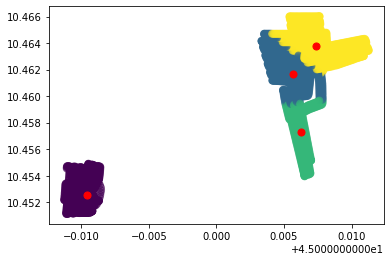

In [70]:
#GEO Clustering attempt
df = DataFrame(LTE_DATA,columns=['gps_param.latitude','gps_param.longitude'])

kmeans = KMeans(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(df['gps_param.latitude'], df['gps_param.longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [106]:
#Lorawan Data Import and Analysis
data = []
with open('LORAWAN.json') as f:
    for line in f:
        data.append(json.loads(line))

LORA_DATA = pd.json_normalize(data)

#Drop duplicate data where rows have same timestamp
LORA_DATA = LORA_DATA.drop_duplicates(subset=['timestamp'])

#Converto DF into float (only numbers)
LORA_DATA = LORA_DATA.apply(pd.to_numeric, errors='ignore')

#Set LORA condition
LORA_Null = LORA_DATA['satellites']>=5
#LORA_net = LORA_DATA['snr'].notna()
#LORA_net = LORA_DATA['gateways'].notna()

#Select only LORA data
LORA_DATA = LORA_DATA[LORA_Null]

#Convert timestamp into datetime
LORA_DATA["timestamp"] = pd.to_datetime(LORA_DATA["timestamp"])

#Sort by time (needed for time clustering)
LORA_DATA = LORA_DATA.sort_values(by="timestamp")

#Print Dtypes for debug
print(LORA_DATA.dtypes)

LORA_DATA.head()

timestamp     datetime64[ns, UTC]
rssi                        int64
snr                       float64
latitude                  float64
longitude                 float64
altitude                  float64
hdop                        int64
satellites                  int64
speed                     float64
head                      float64
gateways                   object
dtype: object


timestamp  rssi  snr   latitude  longitude  \
0    2021-05-22 11:51:27.908408+00:00  -107  6.0  44.990883  10.452408   
2 2021-05-22 11:51:35.448530681+00:00  -109  4.0  44.990757  10.452408   
4 2021-05-22 11:51:42.971167228+00:00  -105  7.0  44.990551  10.452424   
6 2021-05-22 11:51:50.512653127+00:00  -101  9.0  44.990551  10.452423   
8 2021-05-22 11:51:58.016596124+00:00  -109 -0.8  44.990528  10.452511   

    altitude  hdop  satellites     speed   head gateways  
0  22.890625    66          16  0.106384  176.0      NaN  
2  24.578125    66          16  3.937500  177.0      NaN  
4  29.765625    66          16  0.066162  175.0      NaN  
6  38.250000    66          16  0.137207  176.0      NaN  
8  41.625000    66          16  3.958984  105.0      NaN

Found 8 complete flights:
Flight N° 1 has  59  rows of data
Flight N° 2 has  81  rows of data
Flight N° 3 has  184  rows of data
Flight N° 4 has  132  rows of data
Flight N° 5 has  130  rows of data
Flight N° 6 has  135  rows of data
Flight N° 7 has  166  rows of data
Flight N° 8 has  121  rows of data


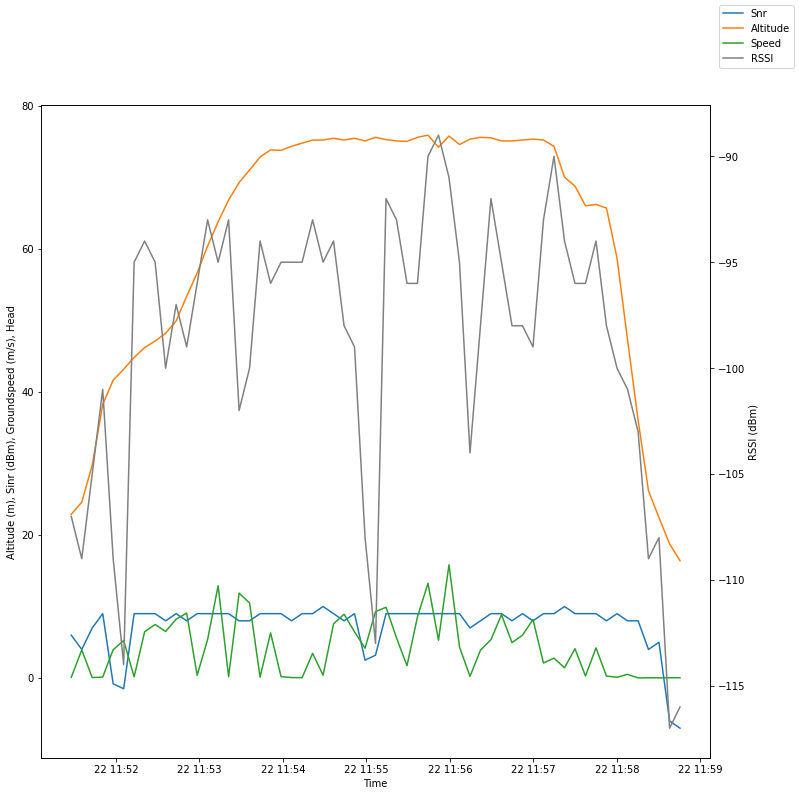

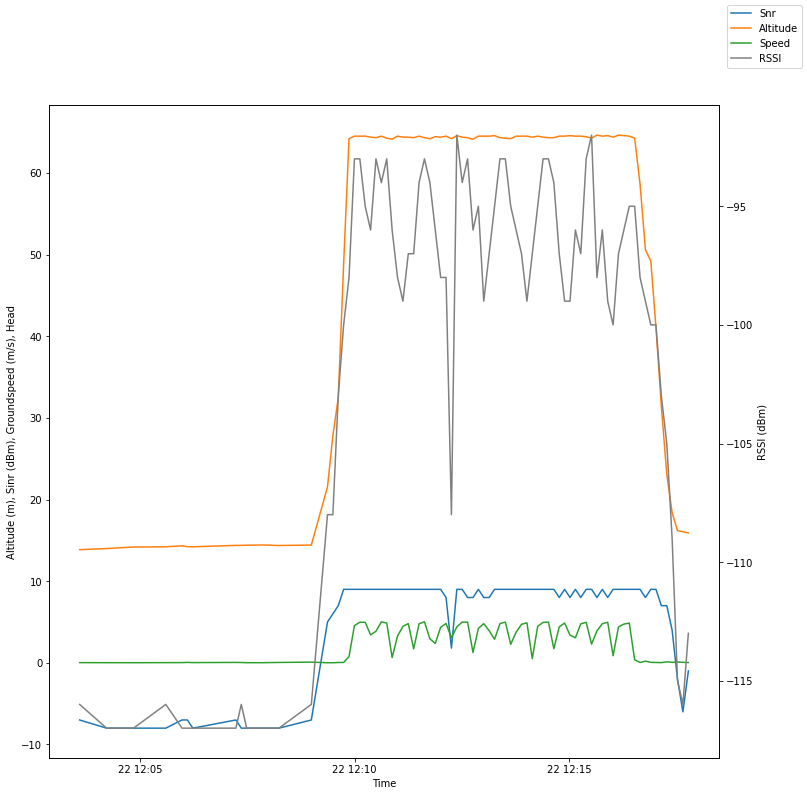

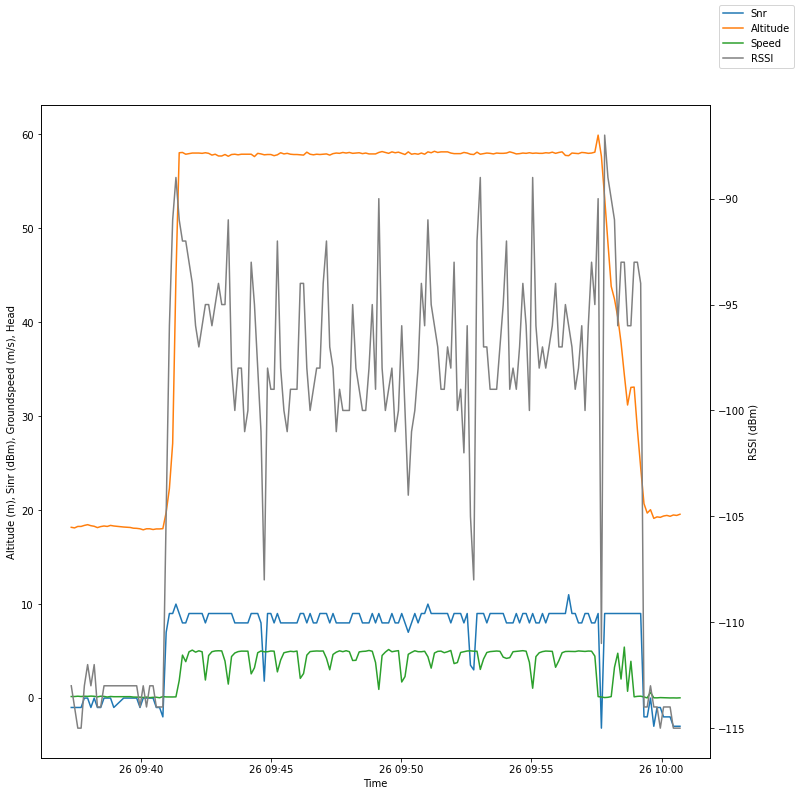

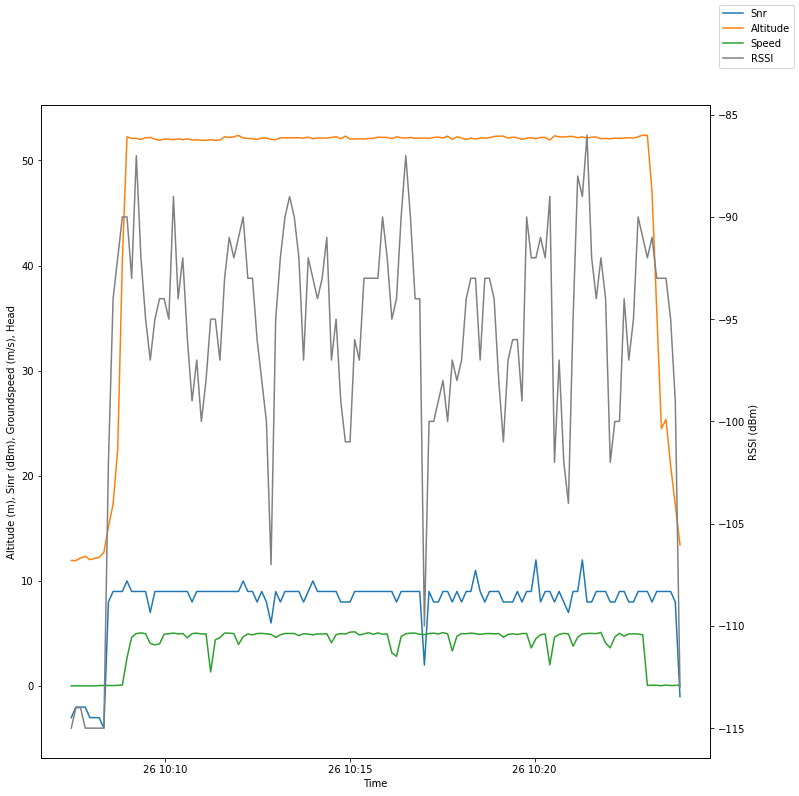

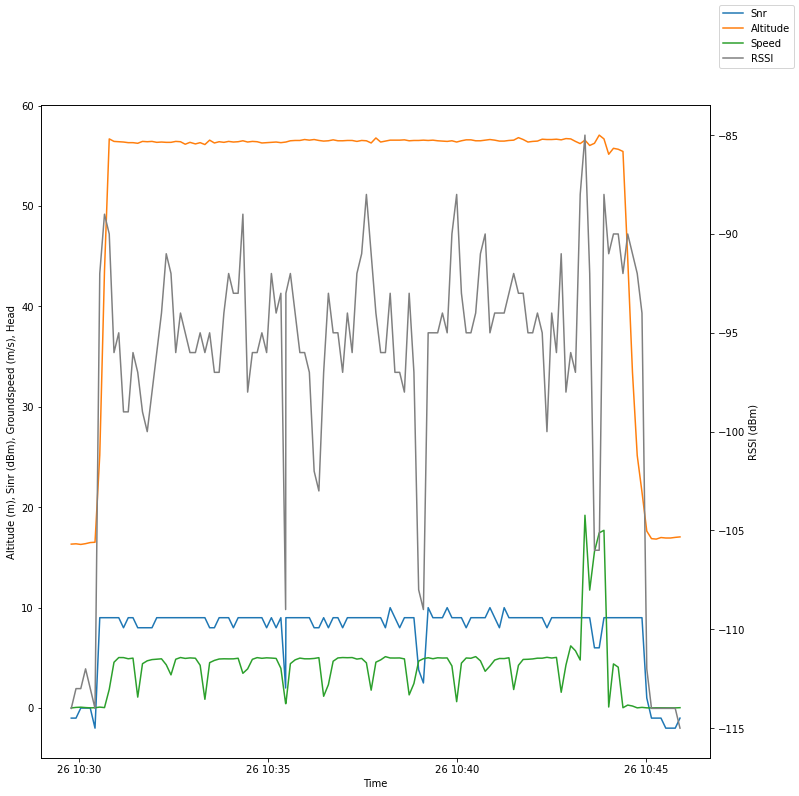

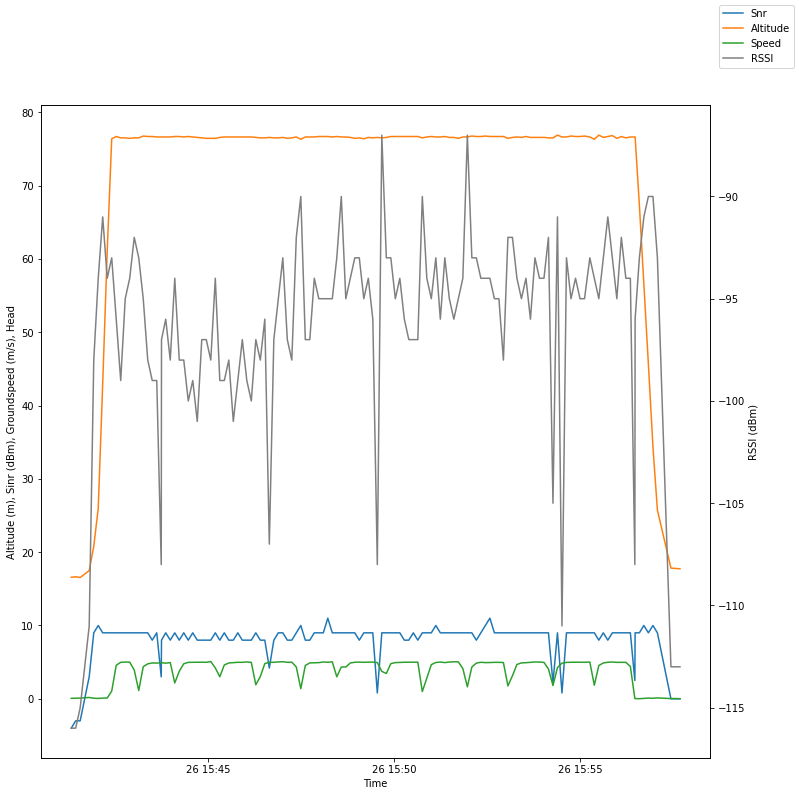

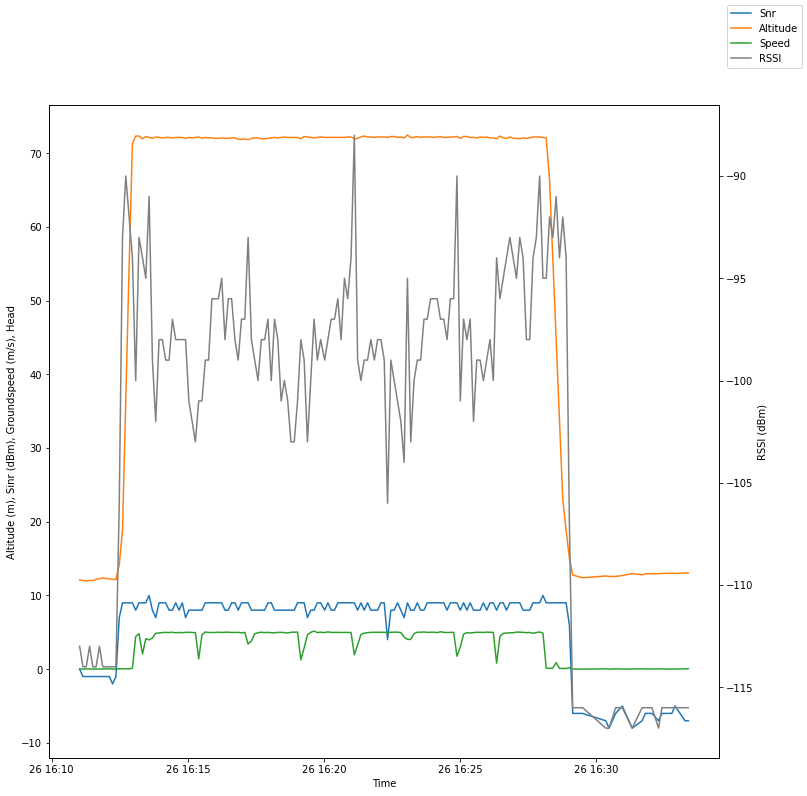

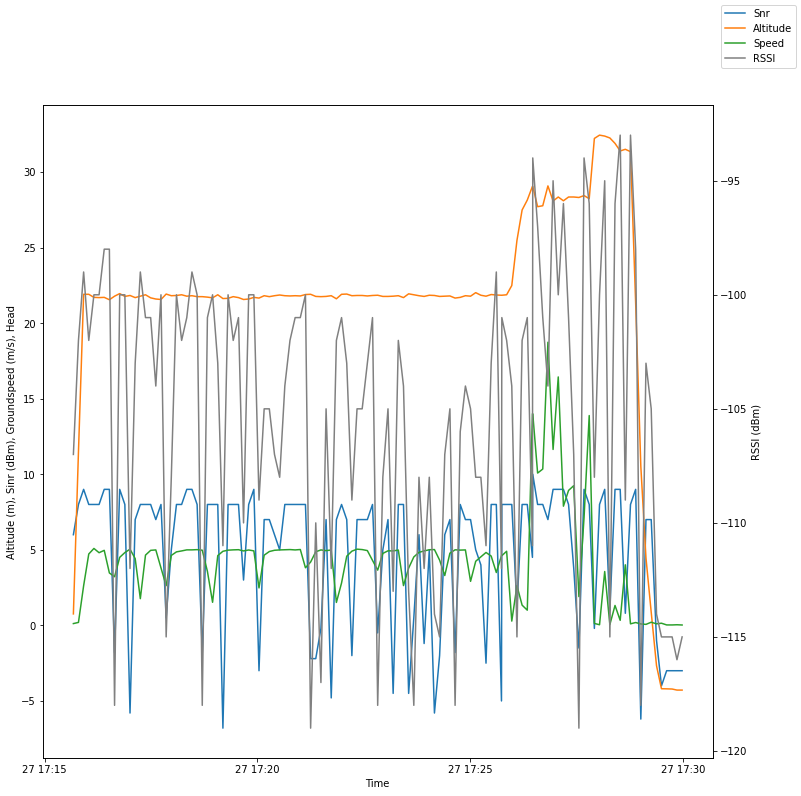

In [107]:
#Convert timestamp of dataframe to python datetime
LORA_DATA.timestamp = LORA_DATA.timestamp.dt.to_pydatetime()

#Define the minimum time difference between flights, in order to identy clusters of data
delta = timedelta(minutes=4)
final = list()
tmp = list()

#First row
tmp.append(LORA_DATA.iloc[0,:])

#First datetime
previous = LORA_DATA.iloc[0,0]

#Scan dataframe looking for clusters and then append them into a list of dataframes
for index, row in islice(LORA_DATA.iterrows(), 1, None):
    dt = row.timestamp
    if dt - previous > delta:
        final.append(tmp)
        tmp = list()
    tmp.append(row)
    previous = dt

#Append last cluster to the list of DF
final.append(tmp)

#Remove flight with less than 50 rows
lora_flights = []
for i in range(len(final)):
    #print(len(final[i]))
    if len(final[i])>50:
        lora_flights.append(final[i])
   
#Remove incomplete flights where there are missing data by check initial and final altitude with a 10 meter error margin due to air pressure change
lora_complete_flights = []
for i in range(len(lora_flights)):
    data = DataFrame (lora_flights[i])
    rth = abs(data.iloc[0,5] - data.iloc[-1,5])
    if rth<10:
        lora_complete_flights.append(data)
    
#Print complete flight
print("Found", len(lora_complete_flights), "complete flights:")
for i in range(len(lora_complete_flights)):
    print("Flight N°", i+1, "has ", len(lora_complete_flights[i]), " rows of data")
    
#Print complete flight data plots
for f in range(len(lora_complete_flights)):
    DF = DataFrame (lora_complete_flights[f])

    #define figures for plots
    fig, ax1 = plt.subplots(figsize = (12, 12))

    #Set first axis data
    ax1.plot(DF['timestamp'], DF['snr'])
    ax1.plot(DF['timestamp'], DF['altitude'])
    ax1.plot(DF['timestamp'], DF['speed'])
    #ax1.plot(DF['timestamp'], DF['head']/10)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Altitude (m), Sinr (dBm), Groundspeed (m/s), Head')
    #Set second axis data
    ax2 = ax1.twinx()
    ax2.plot(DF['timestamp'], DF['rssi'], color='gray')
    ax2.set_ylabel('RSSI (dBm)')
    #Add legend
    fig.legend(['Snr','Altitude','Speed','RSSI'])
    
    
    plot = px.scatter_mapbox(DF, lat='latitude', lon='longitude', color='snr', size='longitude', zoom=16,
                        mapbox_style="open-street-map")
    plot.show()


In [ ]:
#Since there was some missing fields (RSSI and SNR) in the lastest measurment, which where included into gateways, I extracted these value from that field and I rewrite the file with the missing values of RSSI and SNR
for rows in data:
    if 'gateways' in rows:
        #print(rows['gateways'])
        #print(type(rows['gateways']))
        RSSI = []
        SNR = []
        for value in range(len(rows["gateways"])):
            RSSI.append(rows["gateways"][value]["rssi"])
            SNR.append(rows["gateways"][value]["snr"])
        output = {"timestamp":rows["timestamp"],"rssi":max(RSSI), "snr":max(SNR), "latitude":rows['latitude'],"longitude":rows['longitude'],"altitude":rows['altitude'],"hdop":rows['hdop'],"satellites":rows['satellites'],"speed":rows['speed'],"head":rows['head'],"gateways":rows["gateways"]}
        print(output)
    else:
        output = rows
        
    #with open('LORAWAN_CLEAN.json', 'a') as outfile:
        #json.dump(output, outfile, ensure_ascii=False)
        #outfile.write('\n')
        